# Housing EPC ratings - Sagemaker

A Sagemaker instance is run.

In [2]:
# import libraries
#This code imports the required libraries and defines the environment variables you need to prepare the data, train the ML model, and deploy the ML model.
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest',
              'eu-west-2': '205493899709.dkr.ecr.eu-west-2.amazonaws.com/xgboost-neo:'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the eu-west-2 region. You will use the 205493899709.dkr.ecr.eu-west-2.amazonaws.com/xgboost-neo: container for your SageMaker endpoint.


In [3]:
# To display full output in Notebook, instead of only the last result 
from IPython.core.interactiveshell import InteractiveShell 

InteractiveShell.ast_node_interactivity = "all" 

As we already have an S3 bucket where the data is stored, we can proceed with manually uploading our final CSV file into notebook's filepath, in order to proceed with the data pre-processing and setup for ML.

In [31]:
#Option 1:
#Loading the data into a dataframe from S3

bucket = 'ucl-msin0166-2021-london-housing-epc'
subfolder = 'output'

from sagemaker import get_execution_role
role = get_execution_role()

conn = boto3.client('s3')

contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)

for f in contents:
    model_data = pd.read_csv('dexters_epc_ratings.csv',index_col=0)

In [33]:
#Option 2
#Loading the data into a dataframe from locally stored csv

bucket = 'ucl-msin0166-2021-london-housing-epc'
subfolder = 'sagemaker'

from sagemaker import get_execution_role
role = get_execution_role()

conn = boto3.client('s3')

contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']

for f in contents:
    print(f['Key'])

    #loading data manually into diretory # figure out how to change this
try:
    model_data = pd.read_csv('dexters_epc_ratings.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)


sagemaker/
sagemaker/data/train.csv
sagemaker/data/validation.csv
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/profiler-output/system/incremental/2021050102/1619836020.algo-1.json
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/profiler-output/system/incremental/2021050102/1619836080.algo-1.json
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/rule-output/ProfilerReport-1619835886/profiler-output/profiler-report.html
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/rule-output/ProfilerReport-1619835886/profiler-output/profiler-report.ipynb
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/rule-output/ProfilerReport-1619835886/profiler-output/profiler-reports/BatchSize.json
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/rule-output/ProfilerReport-1619835886/profiler-output/profiler-reports/CPUBottleneck.json
sagemaker/output/sagemaker-xgboost-2021-05-01-02-24-46-963/rule-output/ProfilerReport-1619835886/profiler-output/pr

In [34]:
model_data

,street_name,price,address,bedrooms,bathrooms,reception,link,subway_station,distance,efficient,...,tube_line_Hammersmith & City,tube_line_Jubilee,tube_line_Kew Gardens,tube_line_London Overground,tube_line_London Underground,tube_line_Metropolitan,tube_line_Northern,tube_line_Piccadilly,tube_line_Victoria,tube_line_nan
ad_id,,,,,,,,,,,,,,,,,,,,,
151907,Lancaster Gate,23000000.0,"Hyde Park, W2",60,0,1,https://www.dexters.co.uk/property-for-sale/pr...,Lancaster Gate,0.26,0,...,0,0,0,0,0,0,0,0,0,0
151907,Lancaster Gate,23000000.0,"Hyde Park, W2",60,0,1,https://www.dexters.co.uk/property-for-sale/pr...,Lancaster Gate,0.26,0,...,0,0,0,0,0,0,0,0,0,0
159870,Lancaster Gate,1895000.0,"Hyde Park, W2",4,3,1,https://www.dexters.co.uk/property-for-sale/fl...,Lancaster Gate,0.15,0,...,0,0,0,0,0,0,0,0,0,0
159870,Lancaster Gate,1895000.0,"Hyde Park, W2",4,3,1,https://www.dexters.co.uk/property-for-sale/fl...,Lancaster Gate,0.15,0,...,0,0,0,0,0,0,0,0,0,0
124656,Wilton Crescent,19500000.0,"Wilton Crescent, SW1X",5,5,2,https://www.dexters.co.uk/property-for-sale/ho...,Knightsbridge,0.22,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,Kingsland High Street,1325000.0,"Islington, E8",2,3,1,https://www.dexters.co.uk/property-for-sale/fl...,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,1
142375,Maldon Road,1300000.0,"Acton, W3",4,2,2,https://www.dexters.co.uk/property-for-sale/pr...,West Acton,0.72,0,...,0,0,0,0,0,0,0,0,0,0
147283,Kingsland Road,1300000.0,"Bethnal Green, E2",2,2,1,https://www.dexters.co.uk/property-for-sale/fl...,Old Street,0.53,0,...,0,0,0,0,0,0,1,0,0,0


### Pre-processing the data:

In order to process the data and set it up for Machine learning models and deployment, we can use LabelEncoder for the categorical variables like "Street_name", "address", "subway_stations" and drop the "link" column, as it would be irrelevant for this project.

In [6]:
#Use LabelEncoder for the categorical variables listed above
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
model_data.street_name= le.fit_transform(model_data.street_name.values)
model_data.address= le.fit_transform(model_data.address.values)
model_data.subway_station= le.fit_transform(model_data.subway_station.values)
model_data=model_data.drop("link", axis=1)
model_data

,street_name,price,address,bedrooms,bathrooms,reception,subway_station,distance,efficient,average_epc_B,...,tube_line_Hammersmith & City,tube_line_Jubilee,tube_line_Kew Gardens,tube_line_London Overground,tube_line_London Underground,tube_line_Metropolitan,tube_line_Northern,tube_line_Piccadilly,tube_line_Victoria,tube_line_nan
ad_id,,,,,,,,,,,,,,,,,,,,,
151907,133,23000000.0,48,60,0,1,67,0.26,0,0,...,0,0,0,0,0,0,0,0,0,0
151907,133,23000000.0,48,60,0,1,67,0.26,0,0,...,0,0,0,0,0,0,0,0,0,0
159870,133,1895000.0,48,4,3,1,67,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
159870,133,1895000.0,48,4,3,1,67,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
124656,251,19500000.0,119,5,5,2,64,0.22,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,127,1325000.0,50,2,3,1,114,NaN,1,1,...,0,0,0,0,0,0,0,0,0,1
142375,150,1300000.0,0,4,2,2,107,0.72,0,0,...,0,0,0,0,0,0,0,0,0,0
147283,128,1300000.0,7,2,2,1,78,0.53,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
#Shuffle and split the data into training data and test data. Copy and paste the following code into the next code cell and choose Run.
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(265, 29) (114, 29)


In [8]:
#preview train_data
train_data

,street_name,price,address,bedrooms,bathrooms,reception,subway_station,distance,efficient,average_epc_B,...,tube_line_Hammersmith & City,tube_line_Jubilee,tube_line_Kew Gardens,tube_line_London Overground,tube_line_London Underground,tube_line_Metropolitan,tube_line_Northern,tube_line_Piccadilly,tube_line_Victoria,tube_line_nan
ad_id,,,,,,,,,,,,,,,,,,,,,
152608,89,3995000.0,5,4,4,1,92,0.45,0,0,...,0,0,0,0,0,0,0,0,0,0
157317,158,1495000.0,85,3,2,1,90,0.48,0,0,...,0,0,0,0,0,0,0,0,0,0
157876,46,3250000.0,42,3,2,3,76,0.46,0,0,...,0,0,0,0,0,0,1,0,0,0
151775,174,1995000.0,104,5,2,3,114,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
145161,59,2250000.0,15,5,4,1,45,0.66,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153406,214,1675000.0,104,5,3,3,114,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
151165,98,4950000.0,75,3,3,2,69,0.10,0,0,...,0,0,0,0,0,0,0,0,0,0
160949,198,1799999.0,3,3,3,3,25,0.82,0,0,...,0,0,0,0,0,0,1,0,0,0


# Train the XG Boost model

In [9]:
#Check which container corresponds to the XGBoost model 
from sagemaker import image_uris
container=image_uris.retrieve(framework='xgboost',region='eu-west-2',version='1.2-1')
container

'764974769150.dkr.ecr.eu-west-2.amazonaws.com/sagemaker-xgboost:1.2-1'

In [10]:
#according to the other documentation, upload the data like this : 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(['efficient'], axis=1), model_data['efficient'], test_size=0.2, random_state=1)
# X_train_display = X_display.loc[X_train.index]

In [11]:
#Split into validation and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [12]:
#Combine the train sets and name the new dataframes accordingly
import pandas as pd
train = pd.concat([pd.Series(y_train, index=X_train.index), X_train], axis=1)

validation = pd.concat([pd.Series(y_val, index=X_val.index), X_val], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index), X_test], axis=1)

In [13]:
#Save the train and validation datasets to csv
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

In [14]:
#Upload the csv files to the S3 bucket: 

import sagemaker, boto3, os
bucket_name = 'ucl-msin0166-2021-london-housing-epc'
prefix='sagemaker'

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')

In [15]:
#Run the following AWS CLI to check if the CSV files are successfully uploaded to the S3 bucket.
! aws s3 ls {bucket}/{prefix}/data --recursive

2021-05-03 00:35:14      16424 sagemaker/data/train.csv
2021-05-03 00:35:14       5489 sagemaker/data/validation.csv


In [16]:
#Train the model
import sagemaker

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: eu-west-2
RoleArn: arn:aws:iam::849689169827:role/service-role/AmazonSageMaker-ExecutionRole-20210430T103372


In [17]:
! pip install -qU sagemaker

In [18]:
#Define the XGB model parameters
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

764974769150.dkr.ecr.eu-west-2.amazonaws.com/sagemaker-xgboost:1.2-1


In [19]:
#Define the XGB model hyperparameters
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 1000
)

In [20]:
#set up the Training Inputs from the S3 CSV files
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

In [21]:
#Fit the XGB model
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

2021-05-03 00:37:39 Starting - Starting the training job...
2021-05-03 00:38:03 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1620002259: InProgress
......
2021-05-03 00:39:03 Starting - Preparing the instances for training.........
2021-05-03 00:40:33 Downloading - Downloading input data...
2021-05-03 00:41:03 Training - Downloading the training image...
2021-05-03 00:41:40 Uploading - Uploading generated training model[2021-05-03 00:41:26.406 ip-10-0-64-217.eu-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input

In [22]:
#specify the S3 bucket URI where the Debugger training reports are generated and check if the reports exist
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2021-05-03 00:42:02     322338 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-report.html
2021-05-03 00:42:01     168685 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-report.ipynb
2021-05-03 00:41:57        190 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/BatchSize.json
2021-05-03 00:41:57        198 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/CPUBottleneck.json
2021-05-03 00:41:57        126 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/Dataloader.json
2021-05-03 00:41:57        127 sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule

In [23]:
#Download the Debugger XGBoost training and profiling reports to the current workspace:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://ucl-msin0166-2021-london-housing-epc/sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport-1620002259/profiler-output/profiler-reports/LoadBalancing.json
download: s3://ucl-msin0166-2021-london-housing-epc/sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/Dataloader.json to ProfilerReport-1620002259/profiler-output/profiler-reports/Dataloader.json
download: s3://ucl-msin0166-2021-london-housing-epc/sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output/ProfilerReport-1620002259/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport-1620002259/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://ucl-msin0166-2021-london-housing-epc/sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/rule-output

In [24]:
#get the file link of the XGBoost training report:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [25]:
#Checking path
xgb_model.model_data

's3://ucl-msin0166-2021-london-housing-epc/sagemaker/xgboost_model/sagemaker-xgboost-2021-05-03-00-37-39-151/output/model.tar.gz'

# Deploying the model

In [26]:
#hosting a model through Amazon EC2 using Amazon SageMaker
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

-------------------!

In [27]:
#Get the endpoint name
xgb_predictor.endpoint_name

'sagemaker-xgboost-2021-05-03-00-43-04-866'

# Evaluating the model

In [28]:
#Setting up the following function to predict each line of the test set
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

(array([37., 11., 21.,  0.,  1.,  0.,  0.,  4.,  0.,  2.]),
 array([0.05625662, 0.065466  , 0.07467539, 0.08388478, 0.09309416,
        0.10230355, 0.11151293, 0.12072232, 0.12993171, 0.13914109,
        0.14835048]),
 <BarContainer object of 10 artists>)

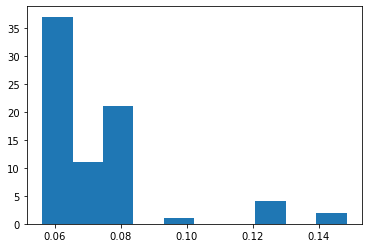

In [29]:
#Plot the predictions
import matplotlib.pyplot as plt

predictions=predict(test.to_numpy()[:,1:])
plt.hist(predictions)
plt.show()

In [30]:
#Show the confusion matrix to evaluate model performance
import sklearn

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[72  0]
 [ 4  0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       0.00      0.00      0.00         4

    accuracy                           0.95        76
   macro avg       0.47      0.50      0.49        76
weighted avg       0.90      0.95      0.92        76



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,